<a href="https://colab.research.google.com/github/RyooKP/Dev-Event/blob/master/test_patent_mlp(simple_code).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""
Title: Multi-label text classification
Description: Implementing a Multi-label text classification model.
"""
"""
## Introduction

The dataset was collected using the
[`arXiv` Python library](https://github.com/lukasschwab/arxiv.py)

that provides a wrapper around the
[original arXiv API](http://arxiv.org/help/api/index).

To learn more about the data collection process, please refer to
[this notebook](https://github.com/soumik12345/multi-label-text-classification/blob/master/arxiv_scrape.ipynb).

Additionally, you can also find the dataset on
[Kaggle](https://www.kaggle.com/spsayakpaul/arxiv-paper-abstracts).
"""

"""
## Imports
"""

from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

from sklearn.model_selection import train_test_split
from ast import literal_eval

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np



In [2]:
"""
Connet Google Drive
"""

from google.colab import drive
drive.mount('/content/drive')

"""
Check nvidia-smi
"""
!nvidia-smi

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Tue Jun 21 05:15:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+------

In [26]:
"""
## Perform exploratory data analysis
In this section, we first load the dataset into a `pandas` dataframe and then perform
some basic exploratory data analysis (EDA).
"""
arxiv_data = pd.read_csv(
    "/content/drive/My Drive/aidisplay/seoyeon/train_en.csv"
    #"https://drive.google.com/file/d/10AFS51WboAVQwdUn56dX27aqQde516o0/"
)
arxiv_data.drop(labels=['Unnamed: 0', '발명의 명칭', '요약', '대표청구항'], axis=1, inplace=True)
arxiv_data.rename(columns={'Current IPC All':'IPC'}, inplace=True)

arxiv_data['IPC'][0]

"['G01V-003/28 ', ' G01V-003/38 ', ' G06F-030/20 ', ' E21B-049/00']"

In [27]:
"""
Our text features are present in the `summaries` column and their corresponding labels
are in `terms`. As you can notice, there are multiple categories associated with a
particular entry.
"""

print(f"There are {len(arxiv_data)} rows in the dataset.")


There are 50000 rows in the dataset.


In [5]:
"""
Real-world data is noisy. One of the most commonly observed source of noise is data
duplication. Here we notice that our initial dataset has got about 13k duplicate entries.
"""

total_duplicate_titles = sum(arxiv_data["CONTEXT"].duplicated())
print(f"There are {total_duplicate_titles} duplicate items.")


There are 2 duplicate items.


In [6]:
"""
Before proceeding further, we drop these entries.
"""

arxiv_data = arxiv_data[~arxiv_data["CONTEXT"].duplicated()]
print(f"There are {len(arxiv_data)} rows in the deduplicated dataset.")

# There are some terms with occurrence as low as 1.
#print("# There are some terms with occurrence as low as 1.", sum(arxiv_data["terms"].value_counts() == 1))

# How many unique terms?
#print("# How many unique terms?", arxiv_data["terms"].nunique())


There are 49998 rows in the deduplicated dataset.


In [7]:
"""
As observed above, out of 3,157 unique combinations of `terms`, 2,321 entries have the
lowest occurrence. To prepare our train, validation, and test sets with
[stratification](https://en.wikipedia.org/wiki/Stratified_sampling), we need to drop
these terms.
"""

# Filtering the rare terms.
arxiv_data_filtered = arxiv_data.groupby("IPC").filter(lambda x: len(x) > 1)
print(arxiv_data_filtered.shape)

(8884, 52)


In [8]:
"""
## Convert the string labels to lists of strings
The initial labels are represented as raw strings. Here we make them `List[str]` for a
more compact representation.
"""

#arxiv_data_filtered["IPC"] = arxiv_data_filtered["IPC"].apply(
#    lambda x: literal_eval(x)
#)
arxiv_data_filtered["IPC"].values[:5]


array(["['C12N-005/071']",
       "['G02F-001/1337 ', ' G02F-001/1343 ', ' G02F-001/137']",
       "['G06F-003/01 ', ' G02B-027/00 ', ' G02B-027/01']",
       "['G06F-003/0354 ', ' G06F-003/041 ', ' G06F-003/046']",
       "['G06F-003/041 ', ' G06F-003/044 ', ' G09G-003/36']"],
      dtype=object)

In [9]:
"""
IPC code가 원문으로 들어가 있는 것을 세부번호를 제외한 G02F 등의 형식으로 표현하는 셀
"""
for i in range(8884) : #len(arxiv_data)) :
    pre_ipc_words = "".join(arxiv_data_filtered['IPC'].values[i][2:-2]).replace(",","").replace("]","").replace(" ","").replace("''","|")
    pre_ipc_words = pre_ipc_words.split("|")
    ipc_words = [ ipc[:4] for ipc in pre_ipc_words ]
    arxiv_data_filtered['IPC'].values[i] = ipc_words

In [10]:
"""
## Use stratified splits because of class imbalance
The dataset has a
[class imbalance problem](https://developers.google.com/machine-learning/glossary/#class-imbalanced-dataset).
So, to have a fair evaluation result, we need to ensure the datasets are sampled with
stratification. To know more about different strategies to deal with the class imbalance
problem, you can follow
[this tutorial](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data).
For an end-to-end demonstration of classification with imbablanced data, refer to
[Imbalanced classification: credit card fraud detection](https://keras.io/examples/structured_data/imbalanced_classification/).
"""

test_split = 0.1

# Initial train and test split.
train_df, test_df = train_test_split(
    arxiv_data_filtered,
    test_size=test_split,
    stratify=arxiv_data_filtered["IPC"].values,
)

# Splitting the test set further into validation
# and new test sets.
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")



Number of rows in training set: 7995
Number of rows in validation set: 444
Number of rows in test set: 445


In [11]:
"""
## Multi-label binarization
Now we preprocess our labels using the
[`StringLookup`](https://keras.io/api/layers/preprocessing_layers/categorical/string_lookup)
layer.
"""

terms = tf.ragged.constant(train_df["IPC"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(terms)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)


print("Vocabulary:\n")
print(vocab)


Vocabulary:

['[UNK]', 'G06F', 'H01L', 'G09G', 'G02F', 'H04L', 'H04N', 'G06Q', 'A61B', 'G06T', 'G02B', 'G07F', 'G06K', 'F21V', 'A63F', 'H04W', 'G11C', 'C07K', 'C09K', 'C07D', 'G01C', 'G16H', 'H04M', 'G01N', 'G05B', 'A61M', 'A61K', 'G06N', 'C12N', 'H05K', 'A61N', 'G01S', 'H05B', 'A61F', 'H02J', 'G09B', 'G10L', 'C09D', 'C08G', 'C23C', 'C07F', 'B32B', 'B25J', 'A63B', 'B60K', 'G09F', 'G03F', 'G05D', 'C07C', 'G03B', 'C03B', 'G11B', 'G08B', 'F21S', 'A47F', 'G08G', 'G01R', 'B41J', 'B60L', 'A01H', 'H04R', 'H04B', 'F24F', 'B60R', 'A01K', 'H01J', 'G01L', 'C03C', 'G07C', 'G01B', 'G03H', 'B65D', 'C12Q', 'H01S', 'G08C', 'G02C', 'C40B', 'B05D', 'A47J', 'G03G', 'H04S', 'H04H', 'H01H', 'H01B', 'G01M', 'G01F', 'D06F', 'C08F', 'B67D', 'B60Q', 'A45C', 'G04G', 'G04B', 'G01V', 'F21W', 'C09J', 'B82Y', 'B66B', 'B60W', 'B29C', 'A61H', 'A01N', 'G05F', 'G01T', 'B64D', 'H01M', 'H01F', 'G01K', 'F21Y', 'F21K', 'C10G', 'C08J', 'B01F', 'B01D', 'A61P', 'A61L', 'A61J', 'A61C', 'A45D', 'H03K', 'B60C', 'A45F', 'H05H', '

In [12]:
"""
Here we are separating the individual unique classes available from the label
pool and then using this information to represent a given label set with 0's and 1's.
Below is an example.
"""

sample_label = train_df["IPC"].iloc[0]
print(f"Sample[0] / Original IPC label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Sample[0] / Label-binarized representation: {label_binarized}")


Sample[0] / Original IPC label: ['G09G', 'H01L']
Sample[0] / Label-binarized representation: [[0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [13]:
"""
## Data preprocessing and `tf.data.Dataset` objects
We first get percentile estimates of the sequence lengths. The purpose will be clear in a
moment.
"""

train_df["CONTEXT"].apply(lambda x: len(x.split(" "))).describe()


count    7995.000000
mean      346.760225
std       131.821707
min        41.000000
25%       258.000000
50%       327.000000
75%       412.000000
max      1064.000000
Name: CONTEXT, dtype: float64

In [14]:
"""
Notice that 50% of the abstracts have a length of 154 (you may get a different number
based on the split). So, any number close to that value is a good enough approximate for the
maximum sequence length.
Now, we implement utilities to prepare our datasets.
"""

max_seqlen = 150
batch_size = 128
padding_token = "<pad>"
auto = tf.data.AUTOTUNE


def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["IPC"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["CONTEXT"].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)


In [15]:
"""
Now we can prepare the `tf.data.Dataset` objects.
"""

train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)


In [16]:
"""
## Dataset preview
"""

text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    print(" ")


Abstract: b'Method of gaming, a gaming system and a game controller. Method and systems of gaming are provided herein. One method includes receiving a credit wager to initiate play of a base game. The method also includes awarding, in a feature game, at least two game rounds including at least an initial game round and a subsequent game round. The method also includes generating a plurality of candidate game outcomes for a plurality of game rounds, and determining, for each of the plurality of candidate game outcomes, an expected benefit to be gained from the respective candidate game outcome when generating a subsequent game outcome in the subsequent game round. The method still further includes selecting a candidate game round of the plurality of candidate game rounds having a candidate game outcome of the plurality of candidate game outcomes associated with a greatest expected benefit, and displaying the selected candidate game round on a display as the initial game round.. 1. An el

In [17]:
"""
## Vectorization
Before we feed the data to our model, we need to vectorize it (represent it in a numerical form).
For that purpose, we will use the
[`TextVectorization` layer](https://keras.io/api/layers/preprocessing_layers/text/text_vectorization).
It can operate as a part of your main model so that the model is excluded from the core
preprocessing logic. This greatly reduces the chances of training / serving skew during inference.
We first calculate the number of unique words present in the abstracts.
"""

# Source: https://stackoverflow.com/a/18937309/7636462
vocabulary = set()
train_df["CONTEXT"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)


56392


In [18]:
"""
We now create our vectorization layer and `map()` to the `tf.data.Dataset`s created
earlier.
"""

text_vectorizer = layers.TextVectorization(
    max_tokens=vocabulary_size, ngrams=2, output_mode="tf_idf"
)

# `TextVectorization` layer needs to be adapted as per the vocabulary from our
# training set.
with tf.device("/CPU:0"):
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
validation_dataset = validation_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)


In [19]:
"""
A batch of raw text will first go through the `TextVectorization` layer and it will
generate their integer representations. Internally, the `TextVectorization` layer will
first create bi-grams out of the sequences and then represent them using
[TF-IDF](https://wikipedia.org/wiki/Tf%E2%80%93idf). The output representations will then
be passed to the shallow model responsible for text classification.
To learn more about other possible configurations with `TextVectorizer`, please consult
the
[official documentation](https://keras.io/api/layers/preprocessing_layers/text/text_vectorization).
**Note**: Setting the `max_tokens` argument to a pre-calculated vocabulary size is
not a requirement.
"""

"""
## Create a text classification model
We will keep our model simple -- it will be a small stack of fully-connected layers with
ReLU as the non-linearity.
"""


def make_model():
    shallow_mlp_model = keras.Sequential(
        [
            layers.Dense(512, activation="relu"),
            layers.Dense(256, activation="relu"),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ]  # More on why "sigmoid" has been used here in a moment.
    )
    return shallow_mlp_model


Epoch 1/3
63/63 [==============================] - 8s 41ms/step - loss: 0.0698 - categorical_accuracy: 0.5466 - val_loss: 0.0133 - val_categorical_accuracy: 0.7252
Epoch 2/3
63/63 [==============================] - 2s 32ms/step - loss: 0.0043 - categorical_accuracy: 0.8389 - val_loss: 0.0133 - val_categorical_accuracy: 0.7545
Epoch 3/3
63/63 [==============================] - 2s 31ms/step - loss: 9.6894e-04 - categorical_accuracy: 0.8538 - val_loss: 0.0149 - val_categorical_accuracy: 0.7432


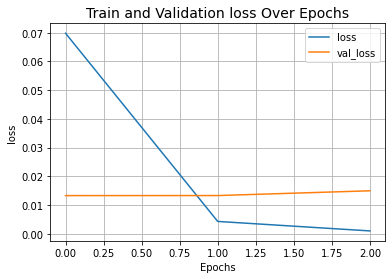

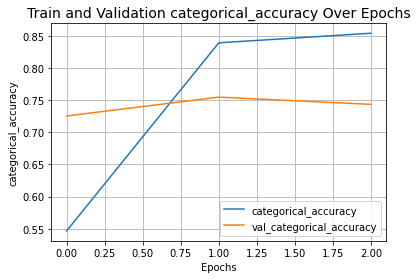

In [20]:
"""
## Train the model
We will train our model using the binary crossentropy loss. This is because the labels
are not disjoint. For a given abstract, we may have multiple categories. So, we will
divide the prediction task into a series of multiple binary classification problems. This
is also why we kept the activation function of the classification layer in our model to
sigmoid. Researchers have used other combinations of loss function and activation
function as well. For example, in
[Exploring the Limits of Weakly Supervised Pretraining](https://arxiv.org/abs/1805.00932),
Mahajan et al. used the softmax activation function and cross-entropy loss to train
their models.
"""
epochs = 3

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["categorical_accuracy"]
)

history = shallow_mlp_model.fit(
    train_dataset, validation_data=validation_dataset, epochs=epochs
)


def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("categorical_accuracy")


In [21]:
"""
While training, we notice an initial sharp fall in the loss followed by a gradual decay.
"""

"""
### Evaluate the model
"""

_, categorical_acc = shallow_mlp_model.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(categorical_acc * 100, 2)}%.")



4/4 [==============================] - 0s 16ms/step - loss: 0.0165 - categorical_accuracy: 0.6876
Categorical accuracy on the test set: 68.76%.


In [22]:
from re import X
"""
The trained model gives us an evaluation accuracy of ~87%.
"""

"""
## Inference
An important feature of the
[preprocessing layers provided by Keras](https://keras.io/guides/preprocessing_layers/)
is that they can be included inside a `tf.keras.Model`. We will export an inference model
by including the `text_vectorization` layer on top of `shallow_mlp_model`. This will
allow our inference model to directly operate on raw strings.
**Note** that during training it is always preferable to use these preprocessing
layers as a part of the data input pipeline rather than the model to avoid
surfacing bottlenecks for the hardware accelerators. This also allows for
asynchronous data processing.
"""

# Create a model for inference.
model_for_inference = keras.Sequential([text_vectorizer, shallow_mlp_model])

# Create a small dataset just for demoing inference.
inference_dataset = make_dataset(test_df.sample(100), is_train=False)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)

# Perform inference.
for i, text in enumerate(text_batch[:3]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    predicted_proba = [proba for proba in predicted_probabilities[i]]

    #print(predicted_proba)
    #print(lookup.get_vocabulary())
    # top_3_labels = [
    #     x
    #     for _, x in sorted(
    #         zip(predicted_probabilities[i], lookup.get_vocabulary()),
    #         key=lambda pair: pair[0],
    #         reverse=True,
    #     )
    # ][:3]
    
    label_table = sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    predicted_label = [ x[1] for x in label_table if x[0] > 0.2 ]
    
    if len(predicted_label) == 0 :
        predicted_label = label_table[0][0]
    
    print(f"Predicted Label(s): ( {', '.join([label for label in predicted_label])} )")
    print(" ")

"""
The prediction results are not that great but not below the par for a simple model like
ours. We can improve this performance with models that consider word order like LSTM or
even those that use Transformers ([Vaswani et al.](https://arxiv.org/abs/1706.03762)).
"""

"""
## Acknowledgements
We would like to thank [Matt Watson](https://github.com/mattdangerw) for helping us
tackle the multi-label binarization part and inverse-transforming the processed labels
to the original form.
"""

Abstract: b'DISPLAY DEVICE AND METHOD FOR MANUFACTURING THE SAME, AND LIGHT-EMITTING DEVICE AND METHOD FOR MANUFACTURING THE SAME. A display device which can achieve increased brightness and resolution and a method for manufacturing the same as well as a light-emitting device and a method for manufacturing the same are provided. The device includes a plurality of light-emitting elements having a first face, arranged in units of subpixels, and having at least one of a first electrically conducting electrode and second electrically conducting electrode on the first face, a substrate having an electrode corresponding to the electrode on the first face of the plurality of light-emitting elements, an anisotropic conductive film providing an anisotropic conductive connection between the electrode on the first face of the plurality of light-emitting elements and the electrode of the substrate, and a wavelength conversion member converting a wavelength of light from the light-emitting elements

'\n## Acknowledgements\nWe would like to thank [Matt Watson](https://github.com/mattdangerw) for helping us\ntackle the multi-label binarization part and inverse-transforming the processed labels\nto the original form.\n'